# UH-WRRC- ASPA  FloPy model of Tutuila Island, draft 7.4
# SWI - Salt Water Interface Model Version

This model is UNDER DEVELOPMENT and is by no means a finished producct!

### Set up cell. Specify modules and paths. hopefully all modules are installed, if not may need to 
- explore the environment.yml file and see if anything is missing from the environment
- explore the local environments to address any issues
- rebuild the environment with environment.yml or manually 

In [1]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container { width: 95%;} div#menubar-container { width: 85%; } div#maintoolbar-container { width: 99%; } </style> """))

%matplotlib notebook

import os
import sys
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from flopy.export.shapefile_utils import shp2recarray
from rasterio import Affine
from flopy.utils.reference import SpatialReference
import shapefile    # not used directly here but for some reason flopy needs this to do shapefile stuff and BTW its not import pyshp as you would think its import shapefile, dumb...
import pandas as pd
import fiona
from rasterio.features import rasterize

from scipy.interpolate import interp2d

GIS_files = os.path.join(".", 'GIS_Data')       # path to the GIS data folder

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
import flopy.utils.binaryfile as bf

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

#Set name of MODFLOW exe
#  assumes executable is in users path statement
exe_name = 'mf2005'
if platform.system() == 'Windows':
    exe_name = 'mf2005.exe'

workspace = os.path.join('Flo_py_wrkspace')
#make sure workspace directory exists
if not os.path.exists(workspace):
    os.makedirs(workspace)
    
WGS84UTM2S_string = 'PROJCS["WGS_1984_UTM_Zone_2S",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-171],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1]]'


flopy is installed in C:\Users\cshuler\Anaconda3\envs\ASPA_Framework\lib\site-packages\flopy
3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)]
numpy version: 1.16.4
matplotlib version: 3.1.1
flopy version: 3.2.12


### model geometry definition 

In [2]:
''' Define the number of layers, rows and columns. The heads are computed quasi-steady state (hence a steady MODFLOW run) while
the interface will move. There are three stress periods with a length of 200, 12, and 18 years and
1,000, 120, and 180 steps.'''

ncol = 200
nrow = 100
nlay = 1

# model run times
nper = 1                     # Number of model stress periods (the default is 1)
perlen = [3650]              # An array of the stress period lengths in days separated by commas
nstp = [1]      # Number of time steps in each stress period (default is 1).
save_head = [3650]
steady = True
rotation = 0                             # rotation (positive counterclockwise)


'''Specify the cell size along the rows (delr) and along the columns (delc) and the top
and bottom of the aquifer for the DIS package.   Note that this block imports model geometry from a polygon shapefile of the area to model '''

# this cell inports the boundary shapefile to make the model around
ra = shp2recarray(os.path.join(GIS_files, 'tut_poly.shp'))
# these are the bondaries of the shapefile
shp_xmin = ra.geometry[0].bounds[0]
shp_ymin = ra.geometry[0].bounds[1]
shp_xmax = ra.geometry[0].bounds[2]
shp_ymax = ra.geometry[0].bounds[3]
print("Shapefile Boundaries: {}".format(ra.geometry[0].bounds))   
#ra.geometry[0].plot() 

xll = int(shp_xmin-(shp_xmax-shp_xmin)*.05)  # Lower left corner of model grid  (note 5% buffer around boundary)
yll = int(shp_ymin-(shp_ymax-shp_ymin)*.05)   # Lower left corner of model grid  (note 5% buffer around boundary)

# grid spacing as a percentage of model x domain (in model units) note 10% buffer around boundary
delr = abs(int((shp_xmax-shp_xmin)*(1/(ncol*.9))))   # row and column spacings   
delc = abs(int((shp_ymax-shp_ymin)*(1/(nrow*.9))))   

delr_4_sr  = np.ones(ncol, dtype=float) * delr    # This just puts the above into an array for the sr object 
delc_4_sr = np.ones(nrow, dtype=float) * delc    

# define the spatial reference object 
model_epsg = 32702   # epsg code specifying coordinate reference system: in this case, UTM zone 2S, WGS 84, A proj4 string has also been fetched from <spatialreference.org> using the supplied epsg code.
sr = SpatialReference(delr=delr_4_sr, delc=delc_4_sr, xll=xll, yll=yll, rotation=rotation, proj4_str=WGS84UTM2S_string, lenuni=2) #  # model length units (1 for feet, 2 for meters (default)) (also calculeted uper left corner of model) 

#print(sr)
#print("corners are at {}".format(sr.get_extent()))

sr.write_shapefile(os.path.join(workspace, 'Model_grid.shp'))          # write a shapefile of the model grid for later use

# output control parameters
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}

Shapefile Boundaries: (516771.84375001956, 8410923.999999458, 547311.6875000503, 8425832.999999477)
wrote Flo_py_wrkspace\Model_grid.shp


<IPython.core.display.Javascript object>


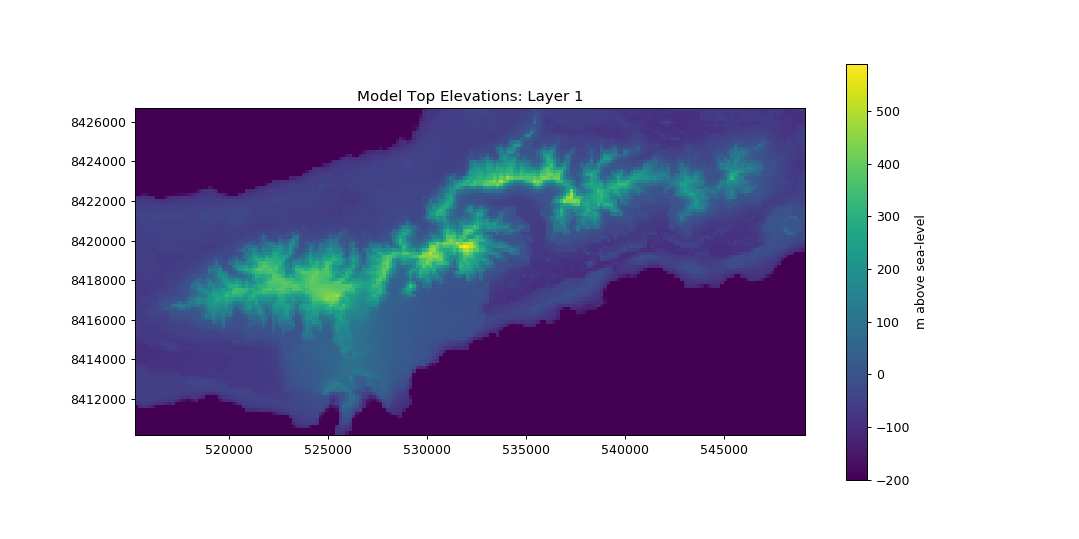

In [3]:
# layer elevations 

Raw_DEM = np.loadtxt(os.path.join(GIS_files, "DEM", '10m_dem_bathy.asc'), skiprows=6)

y = np.linspace(0, np.shape(Raw_DEM)[0]-1, np.shape(Raw_DEM)[0])   # original model cel size
x = np.linspace(0, np.shape(Raw_DEM)[1]-1, np.shape(Raw_DEM)[1])
 
y2 = np.linspace(0, len(y), nrow)       # resampling parameters, len y represents existing number of rows, nrow represents desired number of rows 
x2 = np.linspace(0, len(x), ncol)

f = interp2d(x, y, Raw_DEM, kind='cubic')           # the actual resampling 
top = f(x2, y2)

# Plot
fig, ax = plt.subplots(figsize = (12,6))
qm = sr.plot_array(top, ax=ax, vmin=-200, vmax=None)
ax.set_aspect(1); plt.colorbar(qm).set_label('m above sea-level')
plt.title("Model Top Elevations: Layer 1")

#plt.savefig(os.path.join("Top_elevations.png"), dpi = 300)
# define bottom as flat for now
botm = -1000       # this will clearly need to change to accomadate the Tutuila bathymetry

### GHB boundary condtion definition

This is the general head boundary condition, Little to no user modification needs to be done to this, except for that fact that I dont exactly know how this works, and why it is not keeping the heads in the GHB area consistent at zero or 1 or whatever.  I think I need to do more research into how to use this module and it may need to be modified somewhat. 

<IPython.core.display.Javascript object>


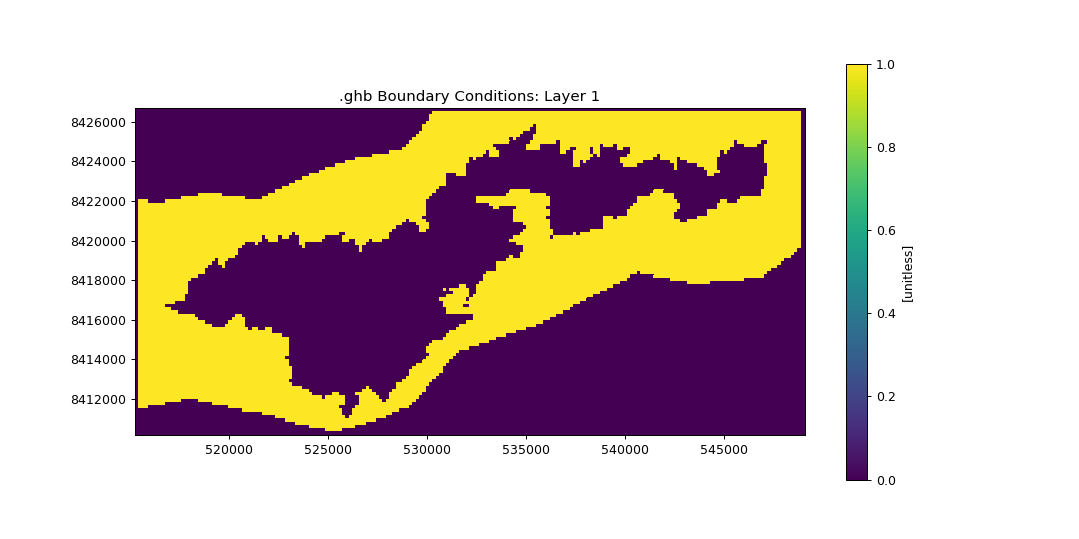

Text(0.5, 1.0, '.ghb Boundary Conditions: Layer 1')

In [4]:
#### Use a Tutuila polygon to define the model active area as the island and the ghb cells as the offshore cells

with fiona.open(os.path.join(GIS_files, 'ibound.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['Ibound'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)

ibound = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

# specify initial head 
ihead = np.ones((nlay, nrow, ncol), dtype=np.float)

#### Use a Tutuila polygon to define the model active area as the island and the ghb cells as the offshore cells

with fiona.open(os.path.join(GIS_files, 'Tut_poly_for_GHB.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src]   
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['Ibound']) for i, g in enumerate(geoms)]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)

Inverse_GHBmap = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 
neg_array = np.ones((nrow, ncol), dtype=np.int)    # this is the shape array
ghb_geometry = (Inverse_GHBmap+neg_array)*ibound

nghb = np.sum(ghb_geometry)     # this is the total number of General head cells in the model

colcell, rowcell = np.meshgrid(np.arange(0, ncol), np.arange(0, nrow))  # make mesh grid lists of all the dell indexes 

lrchc = np.zeros((nghb, 5))       # layer(int), row(int), column(int), stage(float), conductance(float) array pile this is what ghb package needs
lrchc[:, 0] = 0                                    # give it layer 1
lrchc[:, 1] = rowcell[ghb_geometry == 1]           # assign the specific row numbers for the active ghb cells
lrchc[:, 2] = colcell[ghb_geometry == 1]           # assign the specific col numbers for the active ghb cells
lrchc[:, 3] = 1.                                   # this is the starting head value, maybe change to 1?
lrchc[:, 4] = 30                   # this is conductance values, probably change later
# create ghb dictionary
ghb_data = {0:lrchc}

# Plot
fig, ax = plt.subplots(figsize = (12,6))
qm = sr.plot_array(ghb_geometry, ax=ax)
ax.set_aspect(1); plt.colorbar(qm).set_label('[unitless]')
plt.title(".ghb Boundary Conditions: Layer 1")
#plt.savefig(os.path.join("GHB.png"), dpi = 300)

### Water level Observations
These observations are from a text file in the array inputs folder. New water level observations can simply be added to this text file. 
It would be idea for the user to save the new text file to a new name when adding obaservations, in this case the line below: 
    
    "Unique_frame = pd.read_csv(os.path.join('.',  "Array_inputs", 'Observation_data.txt'))"
    
will need to change to reflect tne new observation file name

In [5]:
# load observation values 
Unique_frame = pd.read_csv(os.path.join('.',  "Array_inputs", 'Observation_data.txt'))
# define observation locations and their values & create hobs object to go to model
nobs = len(Unique_frame) 
layervals = [0] * nobs
rowvals = list(Unique_frame['Cell_row'])
colvals = list(Unique_frame['Cell_col'])
obsvals = list(Unique_frame['Water_level_m'])
obsnames = list(Unique_frame['Name'])

### Hyrulic condictivty assigned based on zones as defined by shapefiles in a folder

The values at the top of this cell can be modified to change the conductivity in each zone

<IPython.core.display.Javascript object>


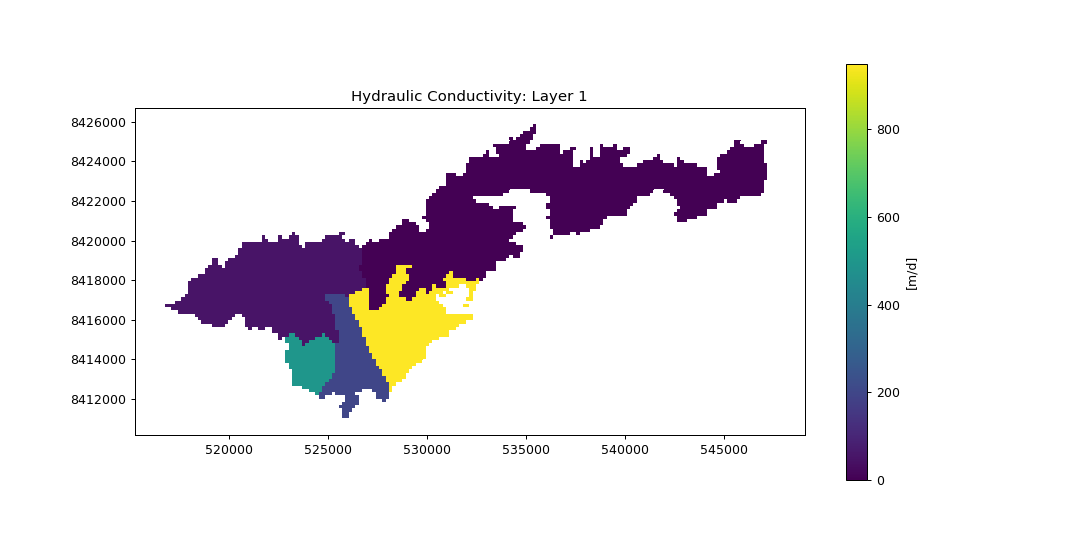

In [6]:
HK_Zone_path = os.path.join(GIS_files, "Simple_1")

Taf_HK = 950
Leo_HK = 500
Pyro_HK = 200
OVtap_HK = 50
OVpag_HK = .45

# Leone 
with fiona.open(os.path.join(HK_Zone_path, 'Leone.shp')) as src:   #    read in Tutuila shapefile
        records = [r for r in src]   
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['par_code']) for i, g in enumerate(geoms)]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
Leone = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

# Tafuna
with fiona.open(os.path.join(HK_Zone_path, 'tafuna.shp')) as src:   #    read in Tutuila shapefile
        records = [r for r in src]   
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['par_code']) for i, g in enumerate(geoms)]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
Tafuna = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

# pyro 
with fiona.open(os.path.join(HK_Zone_path, 'pyro.shp')) as src:   #    read in Tutuila shapefile
        records = [r for r in src]   
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['par_code']) for i, g in enumerate(geoms)]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
Pyro = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

# OldV_tapu
with fiona.open(os.path.join(HK_Zone_path, 'OldV_tapu.shp')) as src:   #    read in Tutuila shapefile
        records = [r for r in src]   
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['par_code']) for i, g in enumerate(geoms)]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
OldV_tapu = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

# OldV_Pago
with fiona.open(os.path.join(HK_Zone_path, 'OldV_Pago.shp')) as src:   #    read in Tutuila shapefile
        records = [r for r in src]   
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['par_code']) for i, g in enumerate(geoms)]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
OldV_Pago = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

HK_raster  = Leone + Tafuna + Pyro + OldV_tapu + OldV_Pago  # merge all zones together

# replace codes with actual HK values 
HK_raster = np.where(HK_raster== -10, Taf_HK, HK_raster) 
HK_raster = np.where(HK_raster== -20, Leo_HK, HK_raster)
HK_raster = np.where(HK_raster== -30, Pyro_HK, HK_raster)
HK_raster = np.where(HK_raster== -60, OVtap_HK, HK_raster)
HK_raster = np.where(HK_raster== -80, OVpag_HK, HK_raster)

HK_raster = np.where(HK_raster== 0, 1, HK_raster)

# Plot
data_masked = np.ma.masked_where(HK_raster == 1, HK_raster)
fig, ax = plt.subplots(figsize = (12,6))
cmap = plt.cm.get_cmap()
cmap.set_bad("white")
qm = sr.plot_array(data_masked, ax=ax, vmin=-0, vmax=None,cmap=cmap )
ax.set_aspect(1); plt.colorbar(qm).set_label('[m/d]')
plt.title("Hydraulic Conductivity: Layer 1")
#plt.savefig(os.path.join("HK.png"), dpi = 300)

'''Define the layers to be confined and define the horizontal and vertical 
hydraulic conductivity of the aquifer for the LPF package.'''

# lpf data
laytyp = 0
hk = HK_raster         # set the HK variable for entry into flopy building 
vka = 300

### Import Recharge .asc from SWB output into MODFLOW rech array
this resamples ascii data from any cell size into the modflow model cell size 
Though I havent tried it will data at a lower resolution than the modflow model...) 

<IPython.core.display.Javascript object>


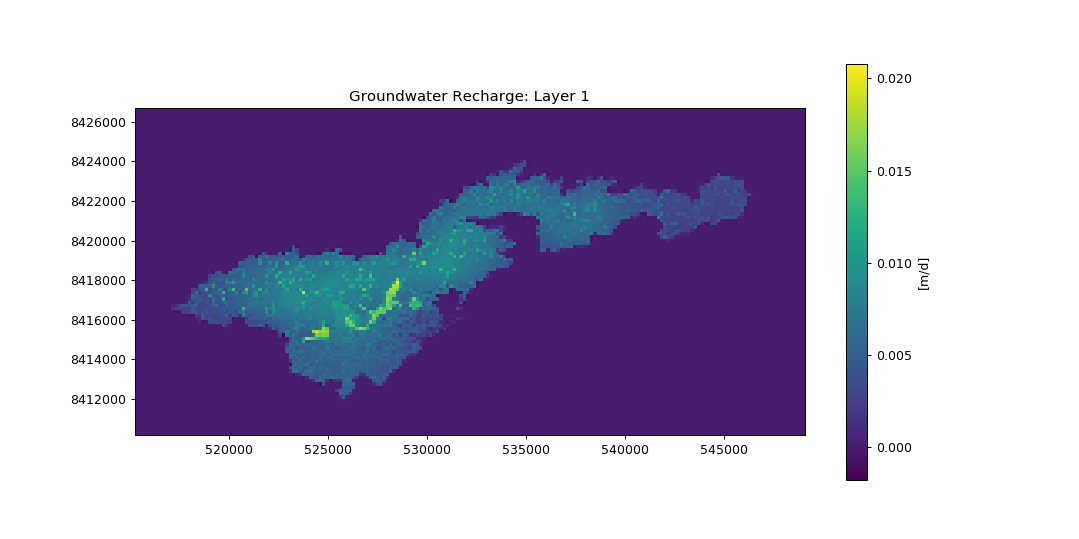

Text(0.5, 1.0, 'Groundwater Recharge: Layer 1')

In [7]:
SWB_output_folder = os.path.join("..", "..", "..", 'ASPA-UH-SWB2_REPO\\output\\post_prcessed_with_MFR')  
recharge_raw_SWB = np.loadtxt(os.path.join(SWB_output_folder, 'net_infiltration_annual.asc'), skiprows=6)
# Uncomment this to load a local static version of the recharge coverage
#recharge_raw_SWB = np.loadtxt(os.path.join(GIS_files, 'net_infiltration_annual.asc'), skiprows=6)

y = np.linspace(0, np.shape(recharge_raw_SWB)[0]-1, np.shape(recharge_raw_SWB)[0])   
x = np.linspace(0, np.shape(recharge_raw_SWB)[1]-1, np.shape(recharge_raw_SWB)[1])

y2 = np.linspace(0, len(y), nrow)       # resampling parameters, len y represents existing number of rows, nrow represents desired number of rows 
x2 = np.linspace(0, len(x), ncol)

f = interp2d(x, y, recharge_raw_SWB, kind='cubic')           # the actual resampling 
recharge_resampled = f(x2, y2)
recharge_converted =  recharge_resampled* (0.0254/365)   # recharge comes out of SWB in inches/year and needs to be converted to m/day

rch_data = {0: recharge_converted}   # dictionary form to specify that it is only on first layer

# Plot
fig, ax = plt.subplots(figsize = (12,6))
qm = sr.plot_array(recharge_converted, ax=ax)
ax.set_aspect(1); plt.colorbar(qm).set_label('[m/d]')
plt.title("Groundwater Recharge: Layer 1")
#plt.savefig(os.path.join("REcharge.png"), dpi = 300)

### SWI saltwater intruction package, basic parameters

In [8]:
### SWI saltwater intruction package, basic parameters

# swi2 data
nadptmx = 10
nadptmn = 1
nu = [0, 0.025]
numult = 5.0
toeslope = nu[1] / numult  #0.005
tipslope = nu[1] / numult  #0.005
z1 = -10.0 * np.ones((nrow, ncol))
z1[ghb_geometry == 0] = -11.0
z = np.array([[z1]])
iso = np.zeros((nlay, nrow, ncol), dtype=np.int)
iso[0, :, :][ghb_geometry == 0] = 1
iso[0, :, :][ghb_geometry == 1] = -2
# iso[1, 70, 71] = 2  # For the well 
ssz=0.2

# swi2 observations  looks like this is observatons at the well, lets disculde this for now
# obsnam = ['layer1_', 'layer2_']
# obslrc=[[0, 30, 35], [1, 30, 35]]
# nobs = len(obsnam)
# iswiobs = 1051

### Time steps and output control print times

In [9]:
# this overwrites the above time step definitaiton and runs the model for much longer
nper = 3
perlen = [365.25 * 200., 365.25 * 12., 365.25 * 18.]
nstp = [1000, 120, 180]
save_head = [200, 60, 60]


"""Create output control (OC) data using words"""

# oc data
spd = {(0,199): ['print budget', 'save head'],
       (0,200): [],
       (0,399): ['print budget', 'save head'],
       (0,400): [],
       (0,599): ['print budget', 'save head'],
       (0,600): [],
       (0,799): ['print budget', 'save head'],
       (0,800): [],
       (0,999): ['print budget', 'save head'],
       (1,0): [],
       (1,59): ['print budget', 'save head'],
       (1,60): [],
       (1,119): ['print budget', 'save head'],
       (1,120): [],
       (2,0): [],
       (2,59): ['print budget', 'save head'],
       (2,60): [],
       (2,119): ['print budget', 'save head'],
       (2,120): [],
       (2,179): ['print budget', 'save head']}

## Build model object - pre-prcess all files 

note: have to figure out why TOP is not working subbing in constant value for now.

In [10]:
modelname = 'modelface'

ml = flopy.modflow.Modflow(modelname, version='mf2005', exe_name=exe_name, model_ws=workspace)

discret = flopy.modflow.ModflowDis(ml, nlay=nlay, nrow=nrow, ncol=ncol, laycbd=0,
                                   delr=delr, delc=delc, top=100, botm=botm,
                                   nper=nper, perlen=perlen, nstp=nstp)
bas = flopy.modflow.ModflowBas(ml, ibound=ibound, strt=ihead)
lpf = flopy.modflow.ModflowLpf(ml, laytyp=laytyp, hk=hk, vka=vka)
ghb = flopy.modflow.ModflowGhb(ml, stress_period_data=ghb_data)
rch = flopy.modflow.ModflowRch(ml, rech=rch_data)

oc = flopy.modflow.ModflowOc(ml, stress_period_data=spd)
pcg = flopy.modflow.ModflowPcg(ml, hclose=1.0e-6, rclose=3.0e-3, mxiter=100, iter1=50)


# water level observations
obs_data= []
for i in range(0,nobs):
    obs = flopy.modflow.HeadObservation(ml, obsname=obsnames[i], layer=layervals[i], row=rowvals[i], column=colvals[i], time_series_data=[[0,obsvals[i]]])
    obs_data.append(obs)
hob = flopy.modflow.ModflowHob(ml, iuhobsv = 7, hobdry=-999, obs_data = obs_data)


#SWI package
swi = flopy.modflow.ModflowSwi2(ml, nsrf=1, istrat=1 , toeslope=toeslope, tipslope=tipslope, 
                                nu=nu,zeta=z, ssz=ssz, isource=iso, nsolver=1,
                                nadptmx=nadptmx, nadptmn=nadptmn, iswizt=55)

### Run MODFLOW

In [11]:
ml.write_input()
ml.run_model(silent=False)

FloPy is using the following  executable to run the model: .\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: modelface.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/07/30 20:59:14

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     8    Ground-Water Flo

 Solving:  Stress period:     1    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   114    Ground-Wa

 Solving:  Stress period:     1    Time step:   208    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   209    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   210    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   211    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   212    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   213    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   214    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   215    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   216    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   217    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   218    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   219    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   220    Ground-Wa

 Solving:  Stress period:     1    Time step:   315    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   316    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   317    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   318    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   319    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   320    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   321    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   322    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   323    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   324    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   325    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   326    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   327    Ground-Wa

 Solving:  Stress period:     1    Time step:   421    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   422    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   423    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   424    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   425    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   426    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   427    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   428    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   429    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   430    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   431    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   432    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   433    Ground-Wa

 Solving:  Stress period:     1    Time step:   527    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   528    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   529    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   530    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   531    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   532    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   533    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   534    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   535    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   536    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   537    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   538    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   539    Ground-Wa

 Solving:  Stress period:     1    Time step:   634    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   635    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   636    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   637    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   638    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   639    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   640    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   641    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   642    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   643    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   644    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   645    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   646    Ground-Wa

 Solving:  Stress period:     1    Time step:   740    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   741    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   742    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   743    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   744    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   745    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   746    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   747    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   748    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   749    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   750    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   751    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   752    Ground-Wa

 Solving:  Stress period:     1    Time step:   846    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   847    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   848    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   849    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   850    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   851    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   852    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   853    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   854    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   855    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   856    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   857    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   858    Ground-Wa

 Solving:  Stress period:     1    Time step:   952    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   953    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   954    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   955    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   956    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   957    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   958    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   959    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   960    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   961    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   962    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   963    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   964    Ground-Wa

 Solving:  Stress period:     2    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    70    Ground-Wa

 Solving:  Stress period:     3    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    56    Ground-Wa

 Solving:  Stress period:     3    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   162    Ground-Wa

(True, [])

<IPython.core.display.Javascript object>


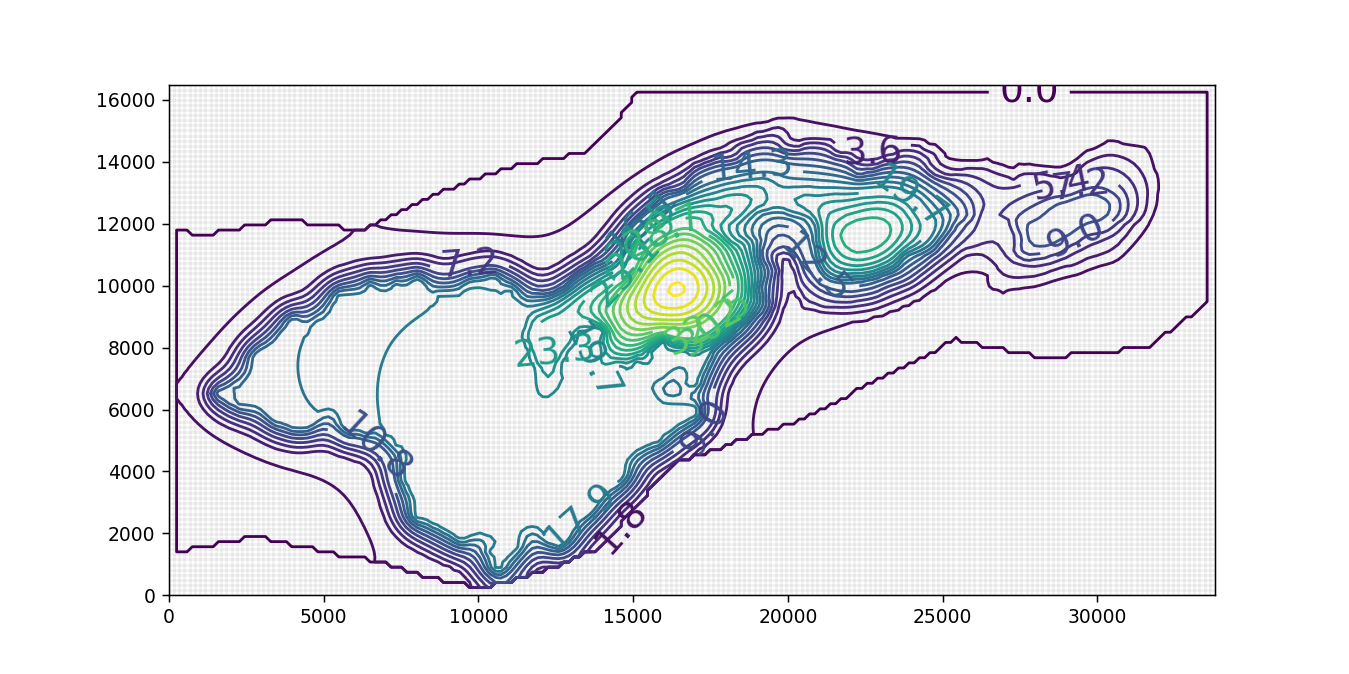

In [16]:
# Post process to graph the results

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

#FV grid extent: (delr/2., Lx - delr/2., delc/2., Ly - delc/2.)
#wpt = ((wcol+0.5)*delr, Lx - ((wrow + 0.5)*delc)) # origing at low upper.. b

hds = bf.HeadFile(os.path.join(workspace, '{}.hds'.format(modelname)))
times = hds.get_times() # simulation time, steady state
head = hds.get_data(totim=times[-1])

##cbb = bf.CellBudgetFile(os.path.join(workspace, '{}.cbc'.format(modelname))) # read budget file
#kstpkper_list = cbb.get_kstpkper()
# cbb.textlist to get a list of data texts
##frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]
##fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]

# flopy plot object
modelmap = flopy.plot.ModelMap(model=ml, layer=0)
# plot grid
lc = modelmap.plot_grid(alpha=.1) # grid
# plot contour

cs = modelmap.contour_array(head, levels=np.linspace(0, int(head.max()), 25)) # head contour
plt.clabel(cs, fontsize=20, fmt='%1.1f') # contour label
# plot discharge quiver
##quiver = modelmap.plot_discharge(frf, fff, head=head, alpha=.4)
plt.show()


## Observed vs Simulated plot

<IPython.core.display.Javascript object>


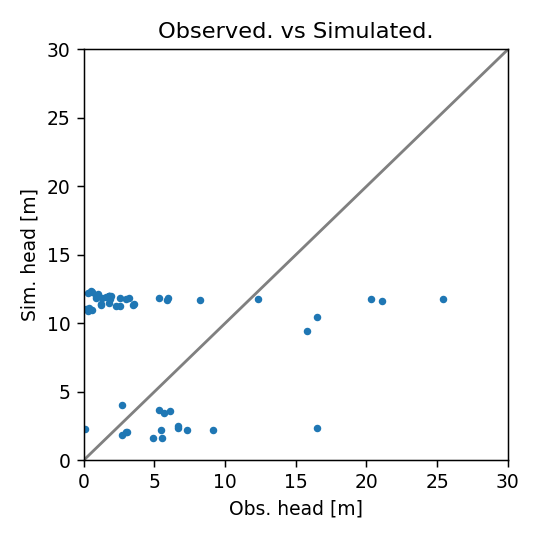

Mean Error: -50.02
Mean Absolute Error: 60.29
RMS Error: 228.32


In [17]:
# plot observations 
observations = np.loadtxt(os.path.join(workspace, '{}.hob.out'.format(modelname)), skiprows=1, usecols=[0,1])      # this block extracts observation data at each well field and determines what the maximum residual at any of the given points is
comp_obs = np.ravel(np.split(observations, 2, 1)[0]) # the computed hed values at the obspts
obs_obs = np.ravel(np.split(observations, 2, 1)[1]) # the observed hed values at the obspts

# note positive residuals means model is calculating too high negative is model calculates too low 
residuals = []
for idx, i in enumerate(observations):   
    r = observations[idx][0]-observations[idx][1]
    residuals.append(r)

Howd_we_do = pd.DataFrame({"Obs_hed_m":obs_obs,"Comp_hed_m":comp_obs,"Residual_m":residuals})

fig = plt.figure(figsize=(4,4))
plt.title('Observed. vs Simulated.')
plt.plot(Howd_we_do["Obs_hed_m"], Howd_we_do["Comp_hed_m"], '.')
#plt.axis('equal')
#plt.axis('square')
plt.xlabel("Obs. head [m]")
plt.ylabel('Sim. head [m]')
plt.ylim(0,30)
plt.xlim(0,30)

plt.plot([0,20,30],[0,20,30], color= "grey")
plt.tight_layout()
plt.savefig("cal.pdf")

plt.show()

me = np.mean(Howd_we_do.Residual_m)
mea = np.mean(np.abs(Howd_we_do.Residual_m))
rmse = np.sqrt(np.mean(Howd_we_do.Residual_m**2))
print ('Mean Error: {:.2f}\nMean Absolute Error: {:.2f}\nRMS Error: {:.2f}'.format(me, mea, rmse))



## Plotting for SWI package

In [19]:
# read base model zeta
zfile = flopy.utils.CellBudgetFile(os.path.join(ml.model_ws, modelname+'.zta'))
kstpkper = zfile.get_kstpkper()
zeta = []
for kk in kstpkper:
    zeta.append(zfile.get_data(kstpkper=kk, text='ZETASRF  1')[0])
zeta = np.array(zeta)


'''Create arrays for plotting the x-coordinates and the output years '''
x = np.linspace(-15000, 15000, 200)
xcell = np.linspace(-15000, 15000, 200) + delr / 2.
xedge = np.linspace(-15250, 15250, 201)
years = [40, 80, 120, 160, 200, 6, 12, 18, 24, 30]

# figure dimensions
fwid, fhgt = 10.00, 5.50
flft, frgt, fbot, ftop = 0.125, 0.95, 0.125, 0.925

# line color definition
icolor = 5
colormap = plt.cm.jet  #winter
cc = []
cr = np.linspace(0.9, 0.0, icolor)
for idx in cr:
    cc.append(colormap(idx))

<IPython.core.display.Javascript object>


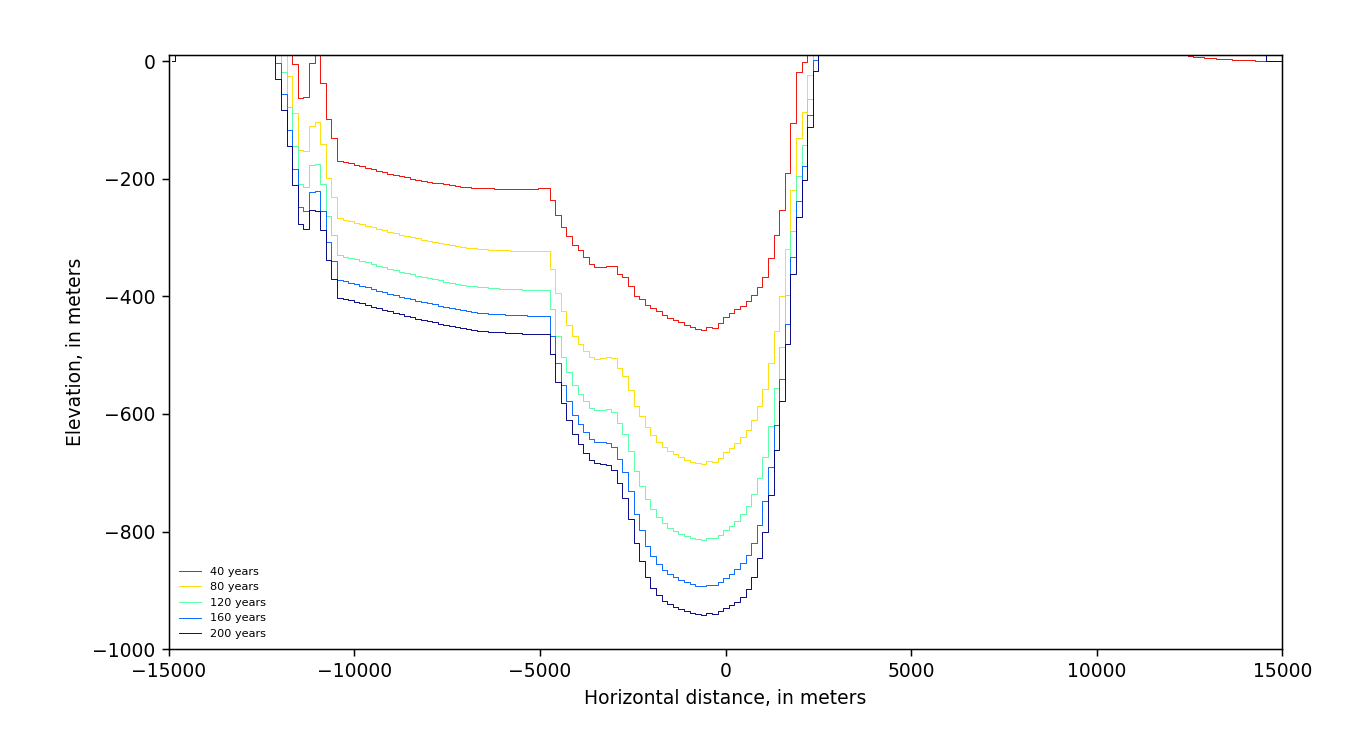

In [22]:
plt.rcParams.update({'legend.fontsize': 6, 'legend.frameon' : False})
fig = plt.figure(figsize=(fwid, fhgt), facecolor='w')
fig.subplots_adjust(wspace=0.25, hspace=0.25, left=flft, right=frgt, bottom=fbot, top=ftop)
# first plot
ax = fig.add_subplot(1, 1, 1)
# axes limits
ax.set_xlim(-15000, 15000)
ax.set_ylim(-1000, 10)
for idx in range(5):
    # layer 1
    ax.plot(xcell, zeta[idx, 0, 45, :], drawstyle='steps-mid', 
            linewidth=0.5, color=cc[idx], label='{:2d} years'.format(years[idx]))
    # layer 2
#    ax.plot(xcell, zeta[idx, 1, 50, :], drawstyle='steps-mid',
#            linewidth=0.5, color=cc[idx], label='_None')
#ax.plot([-15000, 15000], [-30, -30], color='k', linewidth=1.0)
# legend
plt.legend(loc='lower left')
# axes labels and text
ax.set_xlabel('Horizontal distance, in meters')
ax.set_ylabel('Elevation, in meters')




<IPython.core.display.Javascript object>


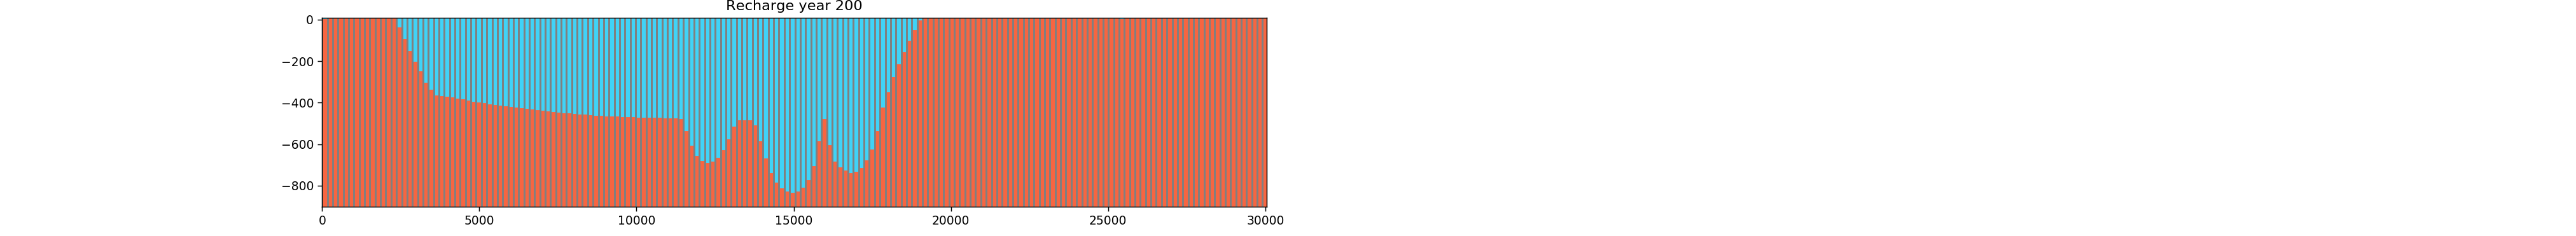

In [24]:
fig = plt.figure(figsize=(fwid*3, fhgt/2))
fig.subplots_adjust(wspace=0.25, hspace=0.25, left=flft, right=frgt, bottom=fbot, top=ftop)

colors = ['#40d3f7', '#F76541']

ax = fig.add_subplot(1, 2, 1)
modelxsect = flopy.plot.ModelCrossSection(model=ml, line={'Row': 50}, 
                                          extent=(0, 30050, -900, 10))
modelxsect.plot_fill_between(zeta[4, :, :, :], colors=colors, ax=ax,
                              edgecolors='none')
linecollection = modelxsect.plot_grid(ax=ax)
ax.set_title('Recharge year {}'.format(years[4]));